## Cleaning House

### Lyrics File
1) Doing things like dropping rows which do not have lyrics seem like a good idea, as these rows will not add to the analysis.<br>
2) You will want to *normalize* text: remove non-alphabetical characters and lemmatize words.

In [1]:
# import pandas and read the song lyrics in
import pandas as pd
song_lyrics = pd.read_csv('./lyrics.csv', index_col = 0)
song_lyrics.head()

,song,year,artist,genre,lyrics
index,,,,,
0,ego-remix,2009,beyonce-knowles,Pop,"Oh baby, how you doing?\nYou know I'm gonna cu..."
1,then-tell-me,2009,beyonce-knowles,Pop,"playin' everything so easy,\nit's like you see..."
2,honesty,2009,beyonce-knowles,Pop,If you search\nFor tenderness\nIt isn't hard t...
3,you-are-my-rock,2009,beyonce-knowles,Pop,"Oh oh oh I, oh oh oh I\n[Verse 1:]\nIf I wrote..."
4,black-culture,2009,beyonce-knowles,Pop,"Party the people, the people the party it's po..."


In [2]:
# drop all songs with no lyrics
song_lyrics = song_lyrics[song_lyrics.lyrics.notnull()].reset_index(drop = True)
len(song_lyrics)

266557

In [3]:
# no elements in lyrics which are strings of length 0
for i in range(len(song_lyrics.lyrics)):
    if len(song_lyrics.lyrics[i]) == 0:
        print(i)

In [4]:
# check for strings with no word characters
import re

no_words = []
for i in range(len(song_lyrics.lyrics)):
    if re.match(r'^[\W_]+$', song_lyrics.lyrics[i]):
        no_words.append(i)

song_lyrics = song_lyrics.drop(no_words).reset_index(drop = True)
len(song_lyrics)

265458

In [5]:
# define function that has input text and output cleaned & normalized text
def lyrics_cleaner(text):
    # First, I want to attempt to remove all instances of non-lyric words in the lyrics, such as
    # 'chorus' or 'verse', etc.
    pattern = re.compile('Chorus|Bridge|Verse( \d*)?',
                         re.IGNORECASE)
    text = pattern.sub('', text)
    
    cleaned_lines = []
    lines = re.split(r'\n', text)
    
    for line in lines:
        # I want to create an if condition that allows me to pass over any empty lines.
        if re.match(r'^$', line):
            continue
        else:
            cleaned_lines.append(line)
    
    # Now, I also want to normalize the text by switching everything to lowercase and dropping all punctuation;
    # however, I think it is useful to keep hyphens so long as they are connecting a single word. Regarding
    # contractions, I think my strategy will be to replace the apostrophe and subsequent letters with the word they
    # represent. The main exception to this will be possessives (ex: John's); however, I think it is unlikely that
    # the word 'is' will have any valence, so it shouldn't affect the positive/negative score.
    cleaned_lyrics = ' '.join(cleaned_lines)
    
    # change everything to lower-case
    lower_lyrics = cleaned_lyrics.lower()
    
    # fix contractions
    partclean_lower_lyrics = lower_lyrics.replace('\'re', ' are').replace('n\'t', ' not').replace('\'m', ' am').replace('\'d', ' would').replace('\'s', ' is')
    words = re.findall(r'\w+', partclean_lower_lyrics)
    
    # Now I will try to account for some slang. This is probably not the most efficient way to do this, and I
    # recognize that many terms will slip past this very naive test.
    slang_dict = {
        'ya': 'you',
        'gonna': 'going to',
        'wanna': 'want to',
        'luv': 'love',
        'lovin': 'loving',
        'hatin': 'hating',
        'bein': 'being'
    }
    
    for word in words:
        if word in slang_dict:
            words[words.index(word)] = slang_dict[word]
    
    normal_clean_lyrics = ' '.join(words)
    
    return normal_clean_lyrics


lyrics_cleaner(song_lyrics.lyrics[3])

'oh oh oh i oh oh oh i if i wrote a book about where we stand then the title of my book would be life with superman that is how you make me feel i count you as a privilege this love is so ideal i am honored to be in it i know you feel the same i see it everyday in all the things you do in all the things you say you are my rock baby you are the truth you are my rock i love to rock with you you are my rock you are everything i need you are my rock so baby rock with me i want to kiss you feel you please you just right i want to touch you love you baby all night reward you for all the things you do you are my rock i love to rock with you i love to rock with you oh oh oh i if i were to try to count the ways you make me smile i would run out of fingers before i run out of timeless things to talk about sugar you keeps it going on make me want to keep my loving strong make me want to try my best to give you what you want and what you need give you my whole heart not just a little piece more th

In [6]:
# now create a lemmatize function
#
# things I will want to catch:
# - past tense ('-ed')
# - plural nouns ('-s')
# - passive verbs and gerunds '-ing'
# - superlatives ('-est', '-er') as in 'fastest' or 'prettier'


def lemmatize(text):
    cleaned_text = lyrics_cleaner(text)
    words = re.findall(r'\w+', cleaned_text) # convert the text into a list of words
    
    for word in words: # iterate through each word in the list
        if re.search(r'e([drs]|st)$', word): # pick up words ending in 'er', 'es', 'est', or 'ed'
            if re.search(r'ie([drs]|st)$', word): # then see if the word ends in 'ier', 'ies', 'iest', or 'ied'
                if len(word) <= 4: # make exceptions for words like 'die', 'lied' and 'dies'
                    words[words.index(word)] = word[:3]
                else:
                    words[words.index(word)] = re.sub(r'ie([drs]|st)$', 'y', word)
                    # note that this will convert 'friendlier' and 'friendliest' to 'friendly'
            else: # if word ends in 'er', 'es', or 'ed', but not 'ier', 'ies', or 'ied'
                if re.search(r're{2}[drs]$', word):# if word ends in 'eer', 'ees', or 'eed'
                    words[words.index(word)] = re.sub(r'[drs]$', '', word)
                    # I acknowledge that this works for words like 'freed', 'trees', and 'need',
                    # but not for words like 'bees'.
                else:
                    if len(word) > 4: # to make an exception for words like 'rest' and 'best'; however, this
                        # also looks over 'doer'
                        words[words.index(word)] = re.sub(r'e([drs]|st)$', '', word)
                        # doesn't work for words like 'truer' or 'matter'
        else: # if word does not end in 'er', 'es', est', or 'ed'
            if re.search(r'[^aeious]s$', word): # look for plural nouns
                words[words.index(word)] = re.sub(r's$', '', word)
            else:
                if re.search(r'ing(s)?$', word): # look for 'ing' verbs and plural 'ing' nouns
                    if re.search(r'ings$', word):
                        words[words.index(word)] = re.sub('s$', '', word)
                        # 'works for mornings' and 'things' but not 'failings'
                    else:
                        if len(word) > 5: # distinguish between 'caring', 'freeing', 'staying', and 'jogging'
                            if re.search(r'[^aeiou][aeiou][^y]ing$', word):
                                # excludes 'blooming' and 'mourning'
                                words[words.index(word)] = re.sub(r'ing$', 'e', word)
                                # doesn't work for words like 'yodeling'
                            else:
                                words[words.index(word)] = re.sub(r'ing$', '', word)
                                # doesn't work for 'everything' - becomes 'everyth'; not important
                                # for this analysis because 'everything' is not on the positive or
                                # negative lists
                        else: # think about words like 'ring', 'doing', 'being', 'bling'
                            if re.search(r'[aeiou]ing$', word):
                                words[words.index(word)] = re.sub(r'ing$', '', word)
    
    # need to create a separate for loop to go back and catch words like 'friendlier' which were changed
    # to adverbs
    for word in words: # iterate through each word in the list again
        if re.search(r'ly', word): # look for adverbs
            words[words.index(word)] = re.sub(r'ly', '', word)
        
    lemma_text = ' '.join(words)
    
    return lemma_text

lemmatize(song_lyrics.lyrics[3])

'oh oh oh i oh oh oh i if i wrote a book about where we stand then the title of my book would be life with superman that is how you make me feel i count you as a privilege this love is so ideal i am honor to be in it i know you feel the same i see it everyday in all the thing you do in all the thing you say you are my rock baby you are the truth you are my rock i love to rock with you you are my rock you are everyth i need you are my rock so baby rock with me i want to kiss you feel you please you just right i want to touch you love you baby all night reward you for all the thing you do you are my rock i love to rock with you i love to rock with you oh oh oh i if i were to try to count the way you make me smile i would run out of finger before i run out of timeless thing to talk about sugar you keep it go on make me want to keep my love strong make me want to try my best to give you what you want and what you need give you my whole heart not just a little piece more than a minimum i am

In [7]:
song_lyrics['norm_lyrics'] = song_lyrics.lyrics.apply(lemmatize)

In [8]:
song_lyrics.norm_lyrics[0:5]

0    oh baby how you do you know i am go to cut rig...
1    playin everyth so easy it is like you seem so ...
2    if you search for tenderness it is not hard to...
3    oh oh oh i oh oh oh i if i wrote a book about ...
4    party the people the people the party it is po...
Name: norm_lyrics, dtype: object

In [9]:
# check to make sure there aren't rows with norm_lyrics of length 0
for i in range(len(song_lyrics.norm_lyrics)):
    if len(song_lyrics.norm_lyrics[i]) == 0:
        print(song_lyrics.lyrics[i])

### Harvard IV-4 File
1) For convenience, go ahead and make two lists from this file, one for positive (Positiv) words and one for negative (Negativ) words.<br>
2) Clean your word lists so they do not have non-alphabetical characters.

In [10]:
# I found the read_excel function here: https://pythonspot.com/read-xls-with-pandas/
harvard = pd.read_excel('./inquireraugmented.xls')
harvard.head()

,Entry,Source,Positiv,Negativ,Pstv,Affil,Ngtv,Hostile,Strong,Power,...,Anomie,NegAff,PosAff,SureLw,If,NotLw,TimeSpc,FormLw,Othrtags,Defined
0,NaN,NaN,1915,2291,1045,557,1160,833,1902,689,...,30,193,126,175,132,25,428,368,NaN,NaN
1,A,H4Lvd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DET ART,| article: Indefinite singular article--some o...
2,ABANDON,H4Lvd,NaN,Negativ,NaN,NaN,Ngtv,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SUPV,|
3,ABANDONMENT,H4,NaN,Negativ,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Noun,|
4,ABATE,H4Lvd,NaN,Negativ,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SUPV,|


In [11]:
# It will be useful later on to remove the rows which have a non-string type 'entry'
harvard = harvard[harvard.Entry.notnull()].reset_index(drop = True)
harvard.head()

,Entry,Source,Positiv,Negativ,Pstv,Affil,Ngtv,Hostile,Strong,Power,...,Anomie,NegAff,PosAff,SureLw,If,NotLw,TimeSpc,FormLw,Othrtags,Defined
0,A,H4Lvd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DET ART,| article: Indefinite singular article--some o...
1,ABANDON,H4Lvd,NaN,Negativ,NaN,NaN,Ngtv,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SUPV,|
2,ABANDONMENT,H4,NaN,Negativ,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Noun,|
3,ABATE,H4Lvd,NaN,Negativ,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SUPV,|
4,ABATEMENT,Lvd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Noun,NaN


In [12]:
# see if there are any words in 'entry' that are not being read as strings
for i in range(0, len(harvard.Entry)):
    if type(harvard.Entry[i]) != str:
        print(harvard.Entry[i])

False


In [13]:
for i in range(len(harvard.Entry)):
    if type(harvard.Entry[i]) != str:
        harvard.Entry[i] = str(harvard.Entry[i])

In [14]:
harvard_positiv = harvard[harvard.Positiv.notnull()]
Positiv = list(harvard_positiv.Entry)

def norm_list(my_list):
    clean_list = []
    
    for word in my_list:
        if re.search(r'#\d+', word):
            clean_list.append(re.sub(r'#\d', '', word).lower())
        else:
            clean_list.append(word.lower())
    
    return clean_list

Positiv = norm_list(Positiv)

In [15]:
harvard_negativ = harvard[harvard.Negativ.notnull()]
Negativ = list(harvard_negativ.Entry)

Negativ = norm_list(Negativ)

In [16]:
# Before removing duplicates, I want to make sure that there isn't any overlap between the sets.
set(Positiv).intersection(set(Negativ))
# Though there is some overlap, rather than trying to determine the valence by context (I'm not sure how I
# could easily get the machine to do this), I will ignore the overlap because the positive and negative
# counts for the overlapping words will cancel each other out.

{'arrest',
 'board',
 'deal',
 'even',
 'fine',
 'fun',
 'hand',
 'help',
 'hit',
 'laugh',
 'make',
 'matter',
 'order',
 'particular',
 'pass'}

In [17]:
# remove duplicates
Negativ = list(set(Negativ))
Negativ.sort()

Positiv = list(set(Positiv))
Positiv.sort()

## The Analysis

In [18]:
#function sentiment_scorer
# Uses user-supplied list to gauge sentiment on an
# arbitrary piece of text.
#
# inputs:
# text_input, a string (representing text to analyze)
# sentiment_list, a list containing words associated
# with a sentiment (e.g., negative)
# output:
# sentiment_score, float
def sentiment_scorer(text_input, sentiment_list):
    sentiment_gross = 0
    
    words = re.findall(r'\w+', text_input)
    
    for word in words:
        if word in sentiment_list:
            sentiment_gross +=1
    
    sentiment_score = sentiment_gross/len(words)
    
    return sentiment_score

In [19]:
sentiment_scorer(song_lyrics.norm_lyrics[3], Negativ)

0.029357798165137616

In [20]:
song_lyrics['positive_sentiment'] = song_lyrics.norm_lyrics.apply(sentiment_scorer, args = (Positiv,))

In [21]:
song_lyrics['negative_sentiment'] = song_lyrics.norm_lyrics.apply(sentiment_scorer, args = (Negativ,))

In [22]:
# apparently there are some years which did not read in correctly, so I need to drop those
years_uniq = song_lyrics.year.unique()
years_uniq.sort()
years_uniq

array([  67,  112,  702, 1968, 1970, 1971, 1972, 1973, 1974, 1975, 1976,
       1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987,
       1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998,
       1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,
       2010, 2011, 2012, 2013, 2014, 2015, 2016])

In [23]:
error_yrs = []
for i in range(len(song_lyrics.year)):
    if song_lyrics.year[i] < 1950:
        error_yrs.append(i)
song_lyrics = song_lyrics.drop(error_yrs).reset_index(drop = True)

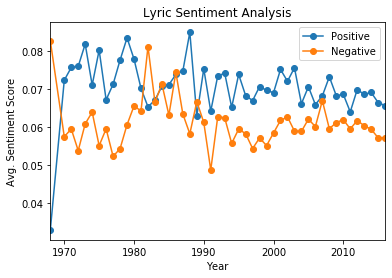

In [68]:
import matplotlib.pyplot as plt

song_lyrics.groupby('year')['positive_sentiment'].mean().plot(kind = 'line', marker = 'o')
song_lyrics.groupby('year')['negative_sentiment'].mean().plot(kind = 'line', marker = 'o')
plt.xlabel('Year')
plt.ylabel('Avg. Sentiment Score')
plt.title('Lyric Sentiment Analysis')
plt.legend(labels = ['Positive', 'Negative'])
plt.show()

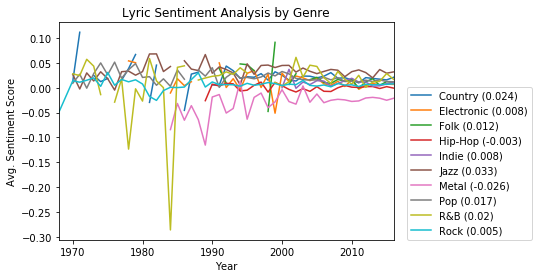

In [25]:
# Found tips on how to move the legend outside of the plot here:
# https://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot
song_lyrics['net_sentiment'] = song_lyrics.positive_sentiment - song_lyrics.negative_sentiment

# I determined it would be more useful for this plot to drop songs which either did not have genre info
# or were put into the 'Other' category. I figured it would be more useful to compare the results for
# known genre categories.
genre_slyrics = song_lyrics[-song_lyrics.genre.isin(['Not Available', 'Other'])]

import numpy as np
df = pd.DataFrame(genre_slyrics.groupby(['genre'])['net_sentiment'].mean())
df.net_sentiment = np.round(df.net_sentiment, 3)
df

label_list = []
for i in range(len(df.net_sentiment)):
    label_list.append(df.index[i] + ' (' + str(df.net_sentiment[i]) + ')')
label_list

genre_slyrics.groupby(['year', 'genre'])['net_sentiment'].mean().unstack().plot(kind = 'line')
plt.xlabel('Year')
plt.ylabel('Avg. Sentiment Score')
plt.title('Lyric Sentiment Analysis by Genre')
plt.legend(labels = label_list, loc = (1.04, 0))
plt.show()

In [26]:
# Why is R&B so negative in 1984?
genre_slyrics[(genre_slyrics.year == 1984) & (genre_slyrics.genre == 'R&B')]
# It's because there is only one R&B song from 1984 in the dataset, and almost every third word is 'killing.'

,song,year,artist,genre,lyrics,norm_lyrics,positive_sentiment,negative_sentiment,net_sentiment
70338,killing-time,1984,big-boys,R&B,This killing time\nIs killing me\nIt's killing...,this kill time is kill me it is kill you it is...,0.0,0.285714,-0.285714


In [27]:
# Inspect all year x genre counts
genre_slyrics.groupby(['year', 'genre']).size()

year  genre  
1968  Rock          1
1970  Country       4
      Jazz         22
      Pop           4
      R&B          12
                 ... 
2016  Jazz        585
      Metal       497
      Pop        1839
      R&B         223
      Rock       2624
Length: 357, dtype: int64

In [28]:
# I have decided to drop all songs for which the year x genre has fewer than 20 songs.
#
# First, I create a data frame with the year, genre, and song count.
df = pd.DataFrame(genre_slyrics.groupby(['year', 'genre'])['song'].count())
df.index.names
#
# Found out how to reset multi-index dataframe created by groupby function here:
# https://stackoverflow.com/questions/20461165/how-to-convert-index-of-a-pandas-dataframe-into-a-column
df = df.reset_index(level = df.index.names)
#
# Now I select those years and genres which have fewer than 20 songs.
fewer_than_20 = df[df.song < 20]
fewer_than_20 = fewer_than_20.reset_index(drop = True)
fewer_than_20 = fewer_than_20.drop('song', axis = 1) # no longer need the song count
fewer_than_20

,year,genre
0,1968,Rock
1,1970,Country
2,1970,Pop
3,1970,R&B
4,1971,Country
...,...,...
89,2002,Folk
90,2002,Indie
91,2002,R&B
92,2004,Indie


In [29]:
# Now I want to get the index for each song in the songs dataframe which corresponds to the year x genre
# values in the fewer_than_20 dataframe.
too_few_songs = []

for i in range(len(fewer_than_20)):
    too_few_songs.append(genre_slyrics[(genre_slyrics.year == fewer_than_20.year[i])
                                   & (genre_slyrics.genre == fewer_than_20.genre[i])].index)
too_few_songs

# too_few_songs is a list of lists which I want to compress into a single list of index values
drop_songs = []
for subList in too_few_songs:
    for item in subList:
        drop_songs.append(item)
        
more_than_20 = genre_slyrics.drop(drop_songs)

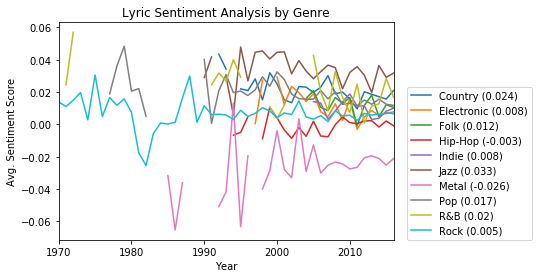

In [42]:
# Redo the label list since dropping years' worth of songs may change the overall genre averages
df = pd.DataFrame(more_than_20.groupby(['genre'])['net_sentiment'].mean())
df.net_sentiment = np.round(df.net_sentiment, 3)
df

label_list = []
for i in range(len(df.net_sentiment)):
    label_list.append(df.index[i] + ' (' + str(df.net_sentiment[i]) + ')')
label_list

# Now plot net sentiment by genre by year, excluding year x genre pairs with fewer than 20 songs.
more_than_20.groupby(['year', 'genre'])['net_sentiment'].mean().unstack().plot(kind = 'line')
plt.xlabel('Year')
plt.ylabel('Avg. Sentiment Score')
plt.title('Lyric Sentiment Analysis by Genre')
plt.legend(labels = label_list, loc = (1.04, 0))
plt.show()

In [31]:
# I want to add all of the year x genre matches for which there is not a net_sentiment value so that the
# below line graphs are discontinuous for years when each particular genre does not have an average
# net_sentiment.
#
# First, I will save the year x genre net_sentiment averages as a separate dataframe:
averages = pd.DataFrame(more_than_20.groupby(['year', 'genre'])['net_sentiment'].mean())
averages = averages.reset_index(level = averages.index.names)
averages

# I read about appending rows to data frames here:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.append.html
# and about how to sort data frames based on column values here:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html
for y in averages.year.unique():
    for g in averages.genre.unique():
        if len(averages[(averages.year == y) & (averages.genre == g)]) == 0:
            averages = averages.append({'year': y, 'genre': g}, ignore_index = True)
averages = averages.sort_values(by = 'year').reset_index(drop = True)
averages

,year,genre,net_sentiment
0,1970,Jazz,0.026489
1,1970,Indie,NaN
2,1970,Folk,NaN
3,1970,Electronic,NaN
4,1970,Hip-Hop,NaN
...,...,...,...
465,2016,Indie,0.010000
466,2016,Jazz,0.031748
467,2016,Metal,-0.021211
468,2016,Pop,0.011800


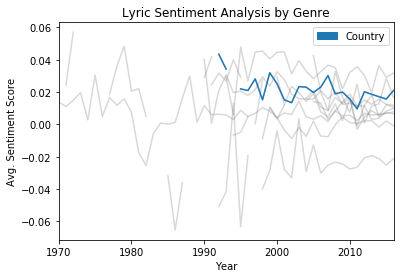

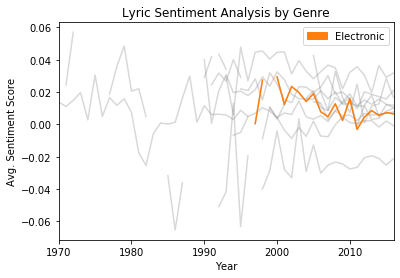

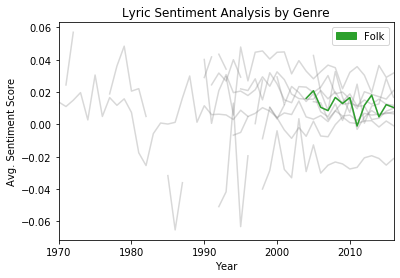

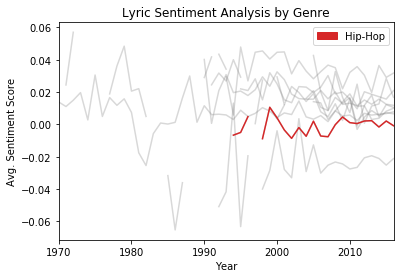

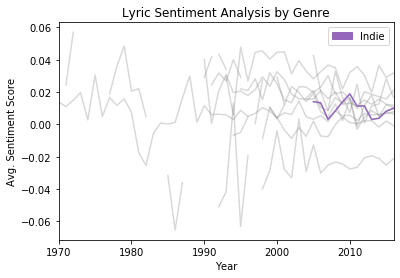

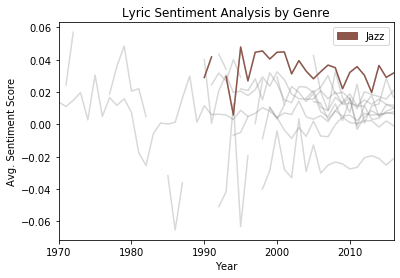

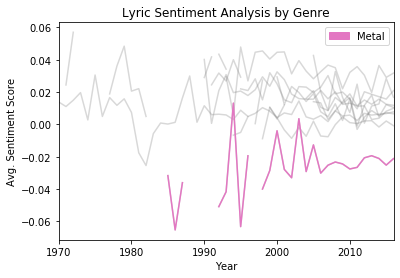

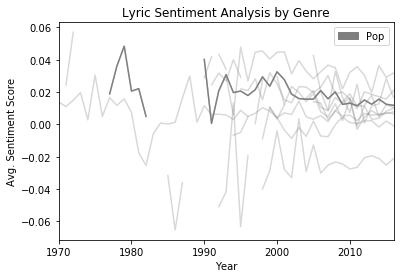

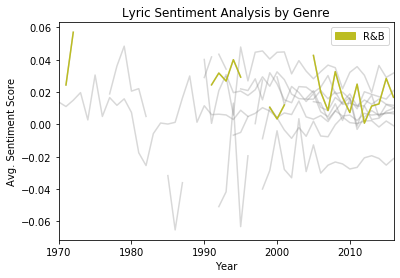

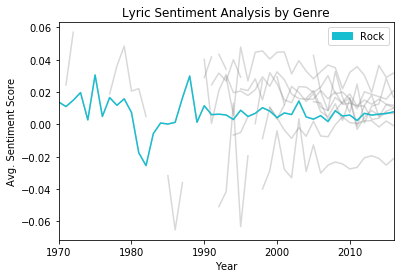

In [32]:
# Got the idea to highlight one line per graph from here:
# https://python-graph-gallery.com/123-highlight-a-line-in-line-plot/
#
# Read about creating artists specifically to add to the legend here:
# https://matplotlib.org/tutorials/intermediate/legend_guide.html
# This will help me "overwrite" the standard legend handles & labels.
import matplotlib.patches as mpatches
#
# Found out how to identify the pyplot default colors here:
# https://matplotlib.org/3.1.1/gallery/color/color_cycle_default.html

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

genres_alph = more_than_20.genre.unique()
genres_alph.sort()
genres_alph = list(genres_alph)

for g in genres_alph:
    more_than_20.groupby(['year', 'genre'])['net_sentiment'].mean().unstack().plot(kind = 'line',
                                                                                   color = 'grey',
                                                                                   alpha = 0.3)
    plt.plot(averages[averages.genre == g]['year'], averages[averages.genre == g]['net_sentiment'],
             color = colors[genres_alph.index(g)])
    plt.xlabel('Year')
    plt.ylabel('Avg. Sentiment Score')
    plt.title('Lyric Sentiment Analysis by Genre')
    patch = mpatches.Patch(color = colors[genres_alph.index(g)], label = g)
    plt.legend(handles = [patch])
    plt.show()